<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Marine-life-forecast---Feature-engineering-and-feature-importance" data-toc-modified-id="Marine-life-forecast---Feature-engineering-and-feature-importance-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Marine life forecast - Feature engineering and feature importance</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Introduction</a></span></li></ul></li><li><span><a href="#Importing-libraries" data-toc-modified-id="Importing-libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Importing libraries</a></span></li><li><span><a href="#Importing-data" data-toc-modified-id="Importing-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Importing data</a></span></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature engineering</a></span><ul class="toc-item"><li><span><a href="#Converting-cyclic-variables-to-sine-and-cosine" data-toc-modified-id="Converting-cyclic-variables-to-sine-and-cosine-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Converting cyclic variables to sine and cosine</a></span></li><li><span><a href="#Categorical-variables" data-toc-modified-id="Categorical-variables-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Categorical variables</a></span></li><li><span><a href="#Continuous-variables" data-toc-modified-id="Continuous-variables-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Continuous variables</a></span></li></ul></li><li><span><a href="#Feature-importance" data-toc-modified-id="Feature-importance-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Feature importance</a></span><ul class="toc-item"><li><span><a href="#Split-data-in-variables-and-target" data-toc-modified-id="Split-data-in-variables-and-target-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Split data in variables and target</a></span></li><li><span><a href="#Categorical-columns" data-toc-modified-id="Categorical-columns-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Categorical columns</a></span><ul class="toc-item"><li><span><a href="#Chi-squared-test" data-toc-modified-id="Chi-squared-test-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Chi-squared test</a></span></li></ul></li><li><span><a href="#Numerical-variables" data-toc-modified-id="Numerical-variables-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Numerical variables</a></span><ul class="toc-item"><li><span><a href="#Anova" data-toc-modified-id="Anova-5.3.1"><span class="toc-item-num">5.3.1&nbsp;&nbsp;</span>Anova</a></span></li></ul></li></ul></li></ul></div>

# Marine life forecast - Feature engineering and feature importance

## Introduction
This notebook covers the feaure engineering and the importance of the features of the dataset. Feature engineering in this notebook is only to study the feature importance. Later, in the model selection notebook all the feature engineering will be integrated in a pipeline (except the hour extraction)

# Importing libraries

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.preprocessing import StandardScaler
from malif.preprocessing import MultilabelEncoder
import matplotlib.style as style
pd.options.display.max_columns = None
style.available
style.use('ggplot')
%config Completer.use_jedi = False # Autocomplete works faster

# Importing data

In [2]:
data_folder = './data/'
input_file = 'occurrence_aggregated.txt'
df = pd.read_csv(data_folder + input_file)

In [3]:
df.head()

,eventDate,month,day,waterBody,countryCode,locality,dive_id,decimalLatitude,decimalLongitude,depth,common_name_order,common_name_family,common_name_genus,common_name_species,common_name,hour,Moray eels,Firefishes,Damselfishes,Sea turtles,Groupers
0,2019-05-29T10:06:00,5,29,South Pacific Ocean,WS,Taliga,2492,-13.9387,-171.553,13.50,turtle,Sea Turtles,green sea turtle,Green turtle,Sea turtles,10,0,0,0,1,0
1,2019-05-29T12:15:00,5,29,South Pacific Ocean,WS,Cowabunga,2493,-13.9387,-171.553,10.20,turtle,Sea Turtles,Hawksbill Sea Turtles,Hawksbill turtle,Sea turtles,12,0,0,0,1,0
2,2019-05-30T12:04:00,5,30,South Pacific Ocean,WS,Cowabunga,2495,-13.9387,-171.553,9.75,turtle,Sea Turtles,green sea turtle,Green turtle,Sea turtles,12,0,0,0,1,0
3,2019-05-30T10:02:00,5,30,South Pacific Ocean,WS,Cowabunga,2494,-13.9387,-171.553,10.50,turtle,Sea Turtles,Hawksbill Sea Turtles,Hawksbill turtle,Sea turtles,10,0,0,0,1,0
4,2015-07-22T18:56:00,7,22,Hidden Lake,EG,Sunrise Grand Select Montemare Resort House Reef,7393,53.8635,-166.049,10.00,perch-like fish,parrotfishes,parrotfishes,Palenose parrotfish,Parrotfishes,18,0,1,0,0,0


# Feature engineering

## Converting cyclic variables to sine and cosine
To represent the cyclic behaviour of hour, day and month, they will be transformr into sine and cosine functions 

In [4]:
def cyclic_transform(df, column, function):
    if column == 'hour':
        steps = 24
    elif column == 'day':
        steps = 31
    elif column == 'month':
        steps = 12
    
    if function == 'sin':
        df[column+'_'+function] = df.apply(lambda row: np.sin(2*np.pi*row[column]/steps), axis=1)
    elif function == 'cos':
        df[column+'_'+function] = df.apply(lambda row: np.cos(2*np.pi*row[column]/steps), axis=1)

In [5]:
cyclic_columns = ['hour', 'day', 'month']

for column in cyclic_columns:
    cyclic_transform(df, column, 'sin')
    cyclic_transform(df, column, 'cos')

In [6]:
df.head()

,eventDate,month,day,waterBody,countryCode,locality,dive_id,decimalLatitude,decimalLongitude,depth,common_name_order,common_name_family,common_name_genus,common_name_species,common_name,hour,Moray eels,Firefishes,Damselfishes,Sea turtles,Groupers,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
0,2019-05-29T10:06:00,5,29,South Pacific Ocean,WS,Taliga,2492,-13.9387,-171.553,13.50,turtle,Sea Turtles,green sea turtle,Green turtle,Sea turtles,10,0,0,0,1,0,5.000000e-01,-8.660254e-01,-0.394356,0.918958,0.5,-0.866025
1,2019-05-29T12:15:00,5,29,South Pacific Ocean,WS,Cowabunga,2493,-13.9387,-171.553,10.20,turtle,Sea Turtles,Hawksbill Sea Turtles,Hawksbill turtle,Sea turtles,12,0,0,0,1,0,1.224647e-16,-1.000000e+00,-0.394356,0.918958,0.5,-0.866025
2,2019-05-30T12:04:00,5,30,South Pacific Ocean,WS,Cowabunga,2495,-13.9387,-171.553,9.75,turtle,Sea Turtles,green sea turtle,Green turtle,Sea turtles,12,0,0,0,1,0,1.224647e-16,-1.000000e+00,-0.201299,0.979530,0.5,-0.866025
3,2019-05-30T10:02:00,5,30,South Pacific Ocean,WS,Cowabunga,2494,-13.9387,-171.553,10.50,turtle,Sea Turtles,Hawksbill Sea Turtles,Hawksbill turtle,Sea turtles,10,0,0,0,1,0,5.000000e-01,-8.660254e-01,-0.201299,0.979530,0.5,-0.866025
4,2015-07-22T18:56:00,7,22,Hidden Lake,EG,Sunrise Grand Select Montemare Resort House Reef,7393,53.8635,-166.049,10.00,perch-like fish,parrotfishes,parrotfishes,Palenose parrotfish,Parrotfishes,18,0,1,0,0,0,-1.000000e+00,-1.836970e-16,-0.968077,-0.250653,-0.5,-0.866025


## Categorical variables
Due to the high cardinality of categorical variables, mean target encoding will be used. Besides, because the target is multilabel, it is necesary to implement a mean target encoder per label in the target. Let's use the the class developed in malif folder.

In [7]:
cat_cols = ['waterBody', 'locality', 'countryCode']
target_cols = ['Moray eels', 'Firefishes', 'Damselfishes', 'Sea turtles', 'Groupers']

mte = MultilabelEncoder()
mte.fit(df[cat_cols], df[target_cols])
df = pd.concat([df, mte.transform(df[cat_cols])], axis=1)

/home/davidgp/anaconda3/envs/malif2/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/davidgp/anaconda3/envs/malif2/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/davidgp/anaconda3/envs/malif2/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/davidgp/anaconda3/envs/malif2/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.type

In [8]:
df.head()

,eventDate,month,day,waterBody,countryCode,locality,dive_id,decimalLatitude,decimalLongitude,depth,common_name_order,common_name_family,common_name_genus,common_name_species,common_name,hour,Moray eels,Firefishes,Damselfishes,Sea turtles,Groupers,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,waterBody_0,locality_0,countryCode_0,waterBody_1,locality_1,countryCode_1,waterBody_2,locality_2,countryCode_2,waterBody_3,locality_3,countryCode_3,waterBody_4,locality_4,countryCode_4
0,2019-05-29T10:06:00,5,29,South Pacific Ocean,WS,Taliga,2492,-13.9387,-171.553,13.50,turtle,Sea Turtles,green sea turtle,Green turtle,Sea turtles,10,0,0,0,1,0,5.000000e-01,-8.660254e-01,-0.394356,0.918958,0.5,-0.866025,0.140496,0.148628,0.007049,0.070248,0.123476,0.005856,0.045455,0.089770,0.004257,0.181818,0.113482,0.957956,0.037190,0.097900,0.004643
1,2019-05-29T12:15:00,5,29,South Pacific Ocean,WS,Cowabunga,2493,-13.9387,-171.553,10.20,turtle,Sea Turtles,Hawksbill Sea Turtles,Hawksbill turtle,Sea turtles,12,0,0,0,1,0,1.224647e-16,-1.000000e+00,-0.394356,0.918958,0.5,-0.866025,0.140496,0.017717,0.007049,0.070248,0.014719,0.005856,0.045455,0.010701,0.004257,0.181818,0.894325,0.957956,0.037190,0.011670,0.004643
2,2019-05-30T12:04:00,5,30,South Pacific Ocean,WS,Cowabunga,2495,-13.9387,-171.553,9.75,turtle,Sea Turtles,green sea turtle,Green turtle,Sea turtles,12,0,0,0,1,0,1.224647e-16,-1.000000e+00,-0.201299,0.979530,0.5,-0.866025,0.140496,0.017717,0.007049,0.070248,0.014719,0.005856,0.045455,0.010701,0.004257,0.181818,0.894325,0.957956,0.037190,0.011670,0.004643
3,2019-05-30T10:02:00,5,30,South Pacific Ocean,WS,Cowabunga,2494,-13.9387,-171.553,10.50,turtle,Sea Turtles,Hawksbill Sea Turtles,Hawksbill turtle,Sea turtles,10,0,0,0,1,0,5.000000e-01,-8.660254e-01,-0.201299,0.979530,0.5,-0.866025,0.140496,0.017717,0.007049,0.070248,0.014719,0.005856,0.045455,0.010701,0.004257,0.181818,0.894325,0.957956,0.037190,0.011670,0.004643
4,2015-07-22T18:56:00,7,22,Hidden Lake,EG,Sunrise Grand Select Montemare Resort House Reef,7393,53.8635,-166.049,10.00,perch-like fish,parrotfishes,parrotfishes,Palenose parrotfish,Parrotfishes,18,0,1,0,0,0,-1.000000e+00,-1.836970e-16,-0.968077,-0.250653,-0.5,-0.866025,0.017717,0.017717,0.209534,0.895516,0.895516,0.278271,0.304300,0.304300,0.130820,0.013527,0.013527,0.129712,0.305269,0.305269,0.073171


## Continuous variables
The only continuous variable is depth. It will be standardized

In [9]:
sc = StandardScaler()
df['depth_std'] = sc.fit_transform(df[['depth']])

In [10]:
df.head()

,eventDate,month,day,waterBody,countryCode,locality,dive_id,decimalLatitude,decimalLongitude,depth,common_name_order,common_name_family,common_name_genus,common_name_species,common_name,hour,Moray eels,Firefishes,Damselfishes,Sea turtles,Groupers,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,waterBody_0,locality_0,countryCode_0,waterBody_1,locality_1,countryCode_1,waterBody_2,locality_2,countryCode_2,waterBody_3,locality_3,countryCode_3,waterBody_4,locality_4,countryCode_4,depth_std
0,2019-05-29T10:06:00,5,29,South Pacific Ocean,WS,Taliga,2492,-13.9387,-171.553,13.50,turtle,Sea Turtles,green sea turtle,Green turtle,Sea turtles,10,0,0,0,1,0,5.000000e-01,-8.660254e-01,-0.394356,0.918958,0.5,-0.866025,0.140496,0.148628,0.007049,0.070248,0.123476,0.005856,0.045455,0.089770,0.004257,0.181818,0.113482,0.957956,0.037190,0.097900,0.004643,0.919043
1,2019-05-29T12:15:00,5,29,South Pacific Ocean,WS,Cowabunga,2493,-13.9387,-171.553,10.20,turtle,Sea Turtles,Hawksbill Sea Turtles,Hawksbill turtle,Sea turtles,12,0,0,0,1,0,1.224647e-16,-1.000000e+00,-0.394356,0.918958,0.5,-0.866025,0.140496,0.017717,0.007049,0.070248,0.014719,0.005856,0.045455,0.010701,0.004257,0.181818,0.894325,0.957956,0.037190,0.011670,0.004643,0.168879
2,2019-05-30T12:04:00,5,30,South Pacific Ocean,WS,Cowabunga,2495,-13.9387,-171.553,9.75,turtle,Sea Turtles,green sea turtle,Green turtle,Sea turtles,12,0,0,0,1,0,1.224647e-16,-1.000000e+00,-0.201299,0.979530,0.5,-0.866025,0.140496,0.017717,0.007049,0.070248,0.014719,0.005856,0.045455,0.010701,0.004257,0.181818,0.894325,0.957956,0.037190,0.011670,0.004643,0.066584
3,2019-05-30T10:02:00,5,30,South Pacific Ocean,WS,Cowabunga,2494,-13.9387,-171.553,10.50,turtle,Sea Turtles,Hawksbill Sea Turtles,Hawksbill turtle,Sea turtles,10,0,0,0,1,0,5.000000e-01,-8.660254e-01,-0.201299,0.979530,0.5,-0.866025,0.140496,0.017717,0.007049,0.070248,0.014719,0.005856,0.045455,0.010701,0.004257,0.181818,0.894325,0.957956,0.037190,0.011670,0.004643,0.237076
4,2015-07-22T18:56:00,7,22,Hidden Lake,EG,Sunrise Grand Select Montemare Resort House Reef,7393,53.8635,-166.049,10.00,perch-like fish,parrotfishes,parrotfishes,Palenose parrotfish,Parrotfishes,18,0,1,0,0,0,-1.000000e+00,-1.836970e-16,-0.968077,-0.250653,-0.5,-0.866025,0.017717,0.017717,0.209534,0.895516,0.895516,0.278271,0.304300,0.304300,0.130820,0.013527,0.013527,0.129712,0.305269,0.305269,0.073171,0.123414


# Feature importance
Here I'll check if variables are correlated with the target. Using SelectKBest from feature selection library I'll apply chi-squared test for categorical varibles and anova for continuous variables

## Split data in variables and target

In [11]:
X = df.drop(columns=target_cols)
Y = df[target_cols]

In [12]:
X.columns

Index(['eventDate', 'month', 'day', 'waterBody', 'countryCode', 'locality',
       'dive_id', 'decimalLatitude', 'decimalLongitude', 'depth',
       'common_name_order', 'common_name_family', 'common_name_genus',
       'common_name_species', 'common_name', 'hour', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'month_sin', 'month_cos', 'waterBody_0',
       'locality_0', 'countryCode_0', 'waterBody_1', 'locality_1',
       'countryCode_1', 'waterBody_2', 'locality_2', 'countryCode_2',
       'waterBody_3', 'locality_3', 'countryCode_3', 'waterBody_4',
       'locality_4', 'countryCode_4', 'depth_std'],
      dtype='object')

## Categorical columns

In [13]:
categorical_columns = ['waterBody_0', 'locality_0', 'countryCode_0',
                       'waterBody_1', 'locality_1', 'countryCode_1',
                       'waterBody_2', 'locality_2', 'countryCode_2',
                       'waterBody_3', 'locality_3', 'countryCode_3',
                       'waterBody_4', 'locality_4', 'countryCode_4']

### Chi-squared test

Chi squared 

Feature waterBody_0 score: 93.605657 p_valor: 2.2555030139248376e-19
Feature locality_0 score: 617.229329 p_valor: 2.891849571398031e-132
Feature countryCode_0 score: 57.630703 p_valor: 9.122037093491549e-12
Feature waterBody_1 score: 123.683397 p_valor: 8.724480551714297e-26
Feature locality_1 score: 622.735603 p_valor: 1.859294462472237e-133
Feature countryCode_1 score: 75.028315 p_valor: 1.9652999349579875e-15
Feature waterBody_2 score: 99.309105 p_valor: 1.380130849286163e-20
Feature locality_2 score: 565.429441 p_valor: 4.692874025144407e-121
Feature countryCode_2 score: 48.652620 p_valor: 6.899055159583764e-10
Feature waterBody_3 score: 94.909925 p_valor: 1.190995135359265e-19
Feature locality_3 score: 709.219840 p_valor: 3.5143286626947474e-152
Feature countryCode_3 score: 48.769377 p_valor: 6.522831291675752e-10
Feature waterBody_4 score: 149.466596 p_valor: 2.648670572397405e-31
Feature locality_4 score: 820.196335 p_valor: 3.2402186948086864e-176
Feature country

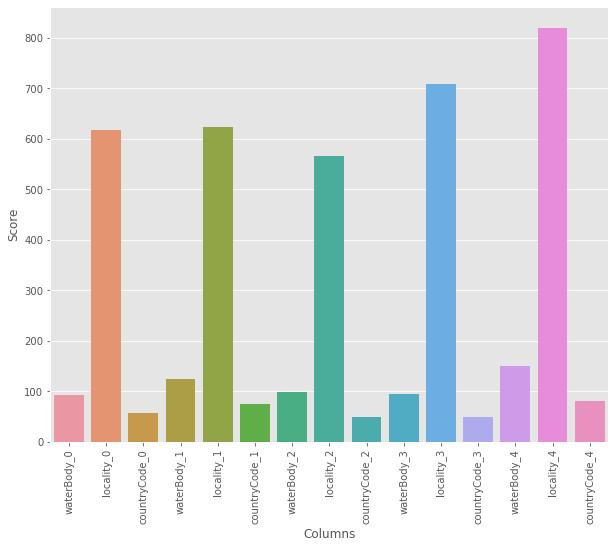

In [28]:
fs_chi2 = SelectKBest(score_func=chi2, k='all')
fs_chi2.fit(X[categorical_columns], Y)
X_fs = fs_chi2.transform(X[categorical_columns])

print('\033[1mChi squared\033[0m', "\n")

for i,col in enumerate(categorical_columns):
    print('Feature \033[1m%s score:\033[0m %f \033[1mp_valor\033[0m: %s' % (col, fs_chi2.scores_[i],\
                                                                            fs_chi2.pvalues_[i]))

plt.figure(figsize=(10,8))
ax=sns.barplot(x=categorical_columns, y=fs_chi2.scores_)
ax.set(xlabel='Columns', ylabel='Score')
plt.xticks(rotation=90)
plt.show()

Moray eels - Chi squared 

Feature waterBody_0 score: 70.252356 p_valor: 5.218292742500684e-17
Feature locality_0 score: 654.396835 p_valor: 2.4711043958913735e-144
Feature countryCode_0 score: 38.035305 p_valor: 6.947602636495884e-10
Feature waterBody_1 score: 17.963294 p_valor: 2.2520596557967428e-05
Feature locality_1 score: 37.839852 p_valor: 7.679682399558453e-10
Feature countryCode_1 score: 14.947268 p_valor: 0.00011055803993097568
Feature waterBody_2 score: 8.613714 p_valor: 0.003336413028435453
Feature locality_2 score: 12.569984 p_valor: 0.0003919919166016219
Feature countryCode_2 score: 4.746298 p_valor: 0.029361387684923565
Feature waterBody_3 score: 4.736253 p_valor: 0.029533328379419115
Feature locality_3 score: 14.393646 p_valor: 0.0001483018776499526
Feature countryCode_3 score: 4.448654 p_valor: 0.0349287658135173
Feature waterBody_4 score: 8.328306 p_valor: 0.0039032036786882203
Feature locality_4 score: 6.917228 p_valor: 0.008536922412166395
Feature countryCode_4 scor

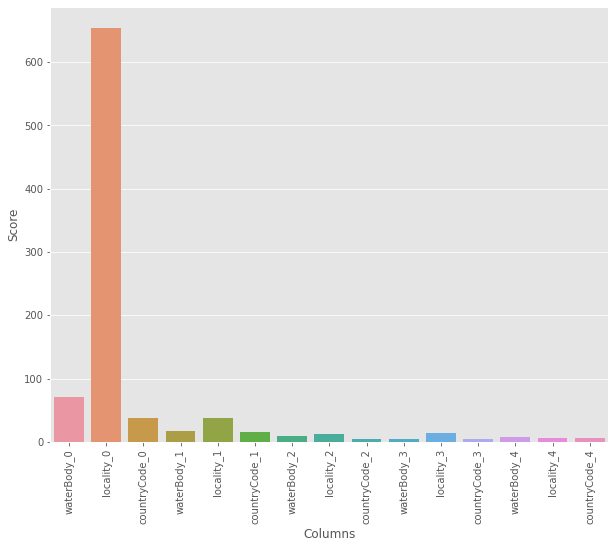

Firefishes - Chi squared 

Feature waterBody_0 score: 17.368384 p_valor: 3.079054657696505e-05
Feature locality_0 score: 35.452800 p_valor: 2.613064326904637e-09
Feature countryCode_0 score: 14.518672 p_valor: 0.00013877717766771138
Feature waterBody_1 score: 108.488777 p_valor: 2.1003620369300274e-25
Feature locality_1 score: 650.013104 p_valor: 2.2195313136708936e-143
Feature countryCode_1 score: 55.180497 p_valor: 1.0995435631058424e-13
Feature waterBody_2 score: 9.670676 p_valor: 0.0018723242128711555
Feature locality_2 score: 20.245015 p_valor: 6.813075686021292e-06
Feature countryCode_2 score: 14.572863 p_valor: 0.00013484248225509635
Feature waterBody_3 score: 4.668962 p_valor: 0.030712491754834297
Feature locality_3 score: 2.026279 p_valor: 0.15459869190731826
Feature countryCode_3 score: 0.972033 p_valor: 0.3241737521356878
Feature waterBody_4 score: 0.651258 p_valor: 0.4196634324936096
Feature locality_4 score: 0.710073 p_valor: 0.39941959439802877
Feature countryCode_4 score

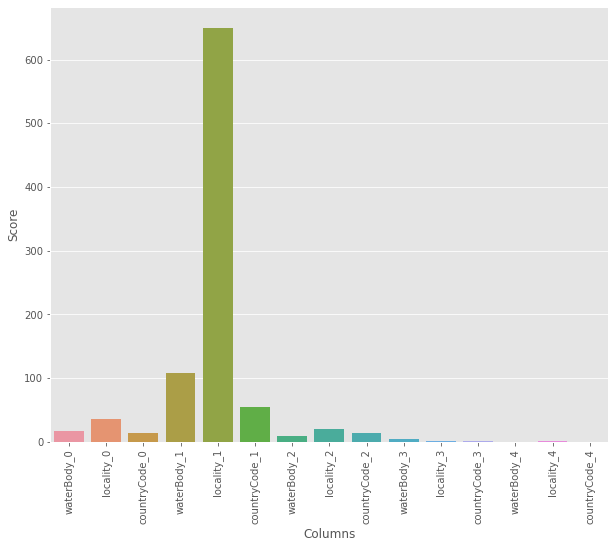

Damselfishes - Chi squared 

Feature waterBody_0 score: 8.136940 p_valor: 0.004337242589745282
Feature locality_0 score: 11.661737 p_valor: 0.0006379876096142915
Feature countryCode_0 score: 4.437846 p_valor: 0.03515056684336624
Feature waterBody_1 score: 9.448308 p_valor: 0.002113439198831871
Feature locality_1 score: 20.046820 p_valor: 7.556909857905825e-06
Feature countryCode_1 score: 14.028040 p_valor: 0.0001801047571404708
Feature waterBody_2 score: 89.458919 p_valor: 3.1307242041010142e-21
Feature locality_2 score: 581.107811 p_valor: 2.153325693566185e-128
Feature countryCode_2 score: 33.408124 p_valor: 7.471122299071707e-09
Feature waterBody_3 score: 1.234530 p_valor: 0.26652788342178235
Feature locality_3 score: 3.642709 p_valor: 0.05631521607914781
Feature countryCode_3 score: 0.409415 p_valor: 0.5222664955367069
Feature waterBody_4 score: 1.055506 p_valor: 0.30424231863997137
Feature locality_4 score: 4.968801 p_valor: 0.02580853029308485
Feature countryCode_4 score: 1.16177

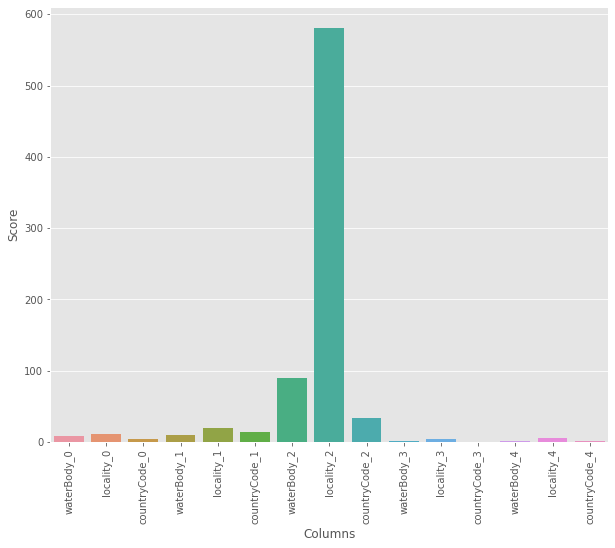

Sea turtles - Chi squared 

Feature waterBody_0 score: 4.559005 p_valor: 0.032746099264011064
Feature locality_0 score: 13.966765 p_valor: 0.00018607085882012424
Feature countryCode_0 score: 4.264566 p_valor: 0.03891518967042461
Feature waterBody_1 score: 4.648170 p_valor: 0.031086666309726414
Feature locality_1 score: 2.098569 p_valor: 0.1474370948827296
Feature countryCode_1 score: 0.959317 p_valor: 0.32735910127679446
Feature waterBody_2 score: 1.257958 p_valor: 0.2620379858823403
Feature locality_2 score: 3.809966 p_valor: 0.05094849549058649
Feature countryCode_2 score: 0.419752 p_valor: 0.5170607425410192
Feature waterBody_3 score: 96.048701 p_valor: 1.1209192324881944e-22
Feature locality_3 score: 779.046280 p_valor: 1.9402262599902878e-171
Feature countryCode_3 score: 48.714561 p_valor: 2.9606021171198196e-12
Feature waterBody_4 score: 0.576901 p_valor: 0.4475294843798783
Feature locality_4 score: 1.376955 p_valor: 0.24062042251502008
Feature countryCode_4 score: 0.643320 p_val

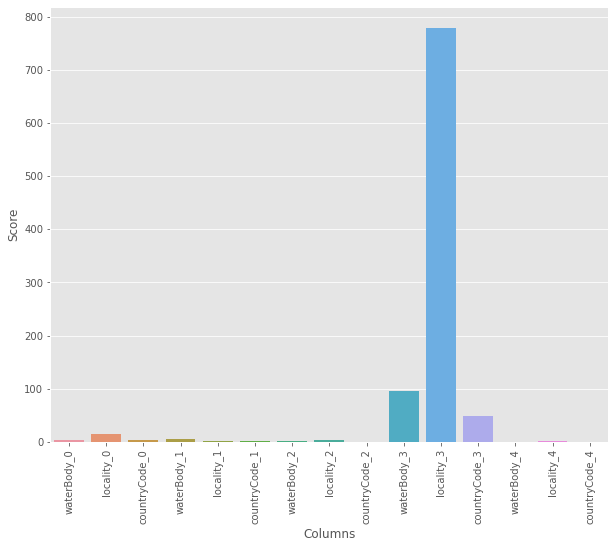

Groupers - Chi squared 

Feature waterBody_0 score: 7.895833 p_valor: 0.004954882207723283
Feature locality_0 score: 6.675892 p_valor: 0.009772557275539629
Feature countryCode_0 score: 5.212797 p_valor: 0.022421232992510445
Feature waterBody_1 score: 0.638588 p_valor: 0.4242226407916606
Feature locality_1 score: 0.731441 p_valor: 0.3924166055307863
Feature countryCode_1 score: 0.350715 p_valor: 0.5537088332405258
Feature waterBody_2 score: 1.059330 p_valor: 0.3033679368256397
Feature locality_2 score: 5.168927 p_valor: 0.022994418426002836
Feature countryCode_2 score: 1.171797 p_valor: 0.27903223139319655
Feature waterBody_3 score: 0.568208 p_valor: 0.4509717407109265
Feature locality_3 score: 1.369532 p_valor: 0.24189233639230953
Feature countryCode_3 score: 0.632889 p_valor: 0.42629765850182666
Feature waterBody_4 score: 155.562618 p_valor: 1.0549842228951225e-35
Feature locality_4 score: 895.622563 p_valor: 8.778606756194941e-197
Feature countryCode_4 score: 82.991674 p_valor: 8.239

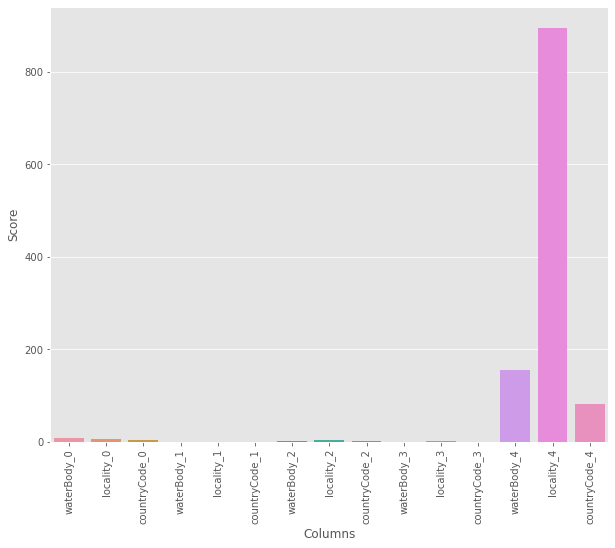

In [29]:
fs_chi2 = SelectKBest(score_func=chi2, k='all')

for col in target_cols:
    fs_chi2.fit(X[categorical_columns], Y[col])
    X_fs = fs_chi2.transform(X[categorical_columns])
    
    print("\033[1m"+col+"\033[0m", '-', '\033[1mChi squared\033[0m', "\n")
    
    for i,col in enumerate(categorical_columns):
        print('Feature \033[1m%s score:\033[0m %f \033[1mp_valor:\033[0m %s' % (col, fs_chi2.scores_[i],\
                                                                                fs_chi2.pvalues_[i]))

    plt.figure(figsize=(10,8))
    ax=sns.barplot(x=categorical_columns, y=fs_chi2.scores_)
    ax.set(xlabel='Columns', ylabel='Score')
    plt.xticks(rotation=90)
    plt.show()

All variables are correlated with the target, but it seems that locality is the one that most influences

## Numerical variables

In [18]:
numerical_columns = ['hour_sin', 'hour_cos', 'day_sin',
                     'day_cos', 'month_sin', 'month_cos', 'depth_std']

### Anova

Moray eels - Anova 

Feature hour_sin score: 3.787051 p_valor: 0.05167427666146757
Feature hour_cos score: 0.359640 p_valor: 0.5487179672423235
Feature day_sin score: 11.488822 p_valor: 0.0007024512419164439
Feature day_cos score: 2.785104 p_valor: 0.09517104574431413
Feature month_sin score: 0.092230 p_valor: 0.7613667115121369
Feature month_cos score: 14.280170 p_valor: 0.0001582902160972456
Feature depth_std score: 68.339306 p_valor: 1.5233699420260342e-16


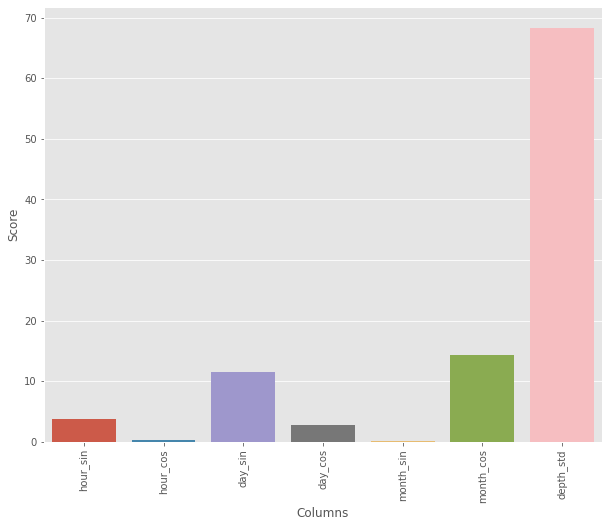

Firefishes - Anova 

Feature hour_sin score: 0.896644 p_valor: 0.34370262641459015
Feature hour_cos score: 1.880502 p_valor: 0.17030316473818108
Feature day_sin score: 5.375223 p_valor: 0.02044172391845193
Feature day_cos score: 0.002154 p_valor: 0.9629863676663794
Feature month_sin score: 1.680184 p_valor: 0.19492535540738382
Feature month_cos score: 9.637717 p_valor: 0.0019107297334280703
Feature depth_std score: 15.877038 p_valor: 6.800002912897942e-05


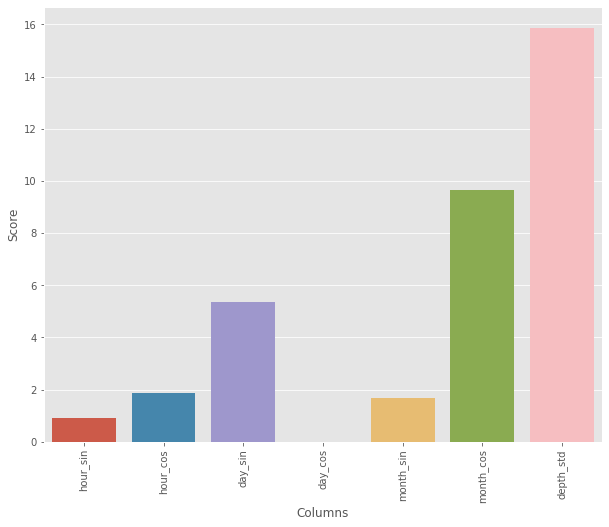

Damselfishes - Anova 

Feature hour_sin score: 7.248847 p_valor: 0.007104665737538069
Feature hour_cos score: 2.023853 p_valor: 0.15487223870796188
Feature day_sin score: 1.761488 p_valor: 0.18446464844466162
Feature day_cos score: 0.103547 p_valor: 0.7476192435198656
Feature month_sin score: 5.583523 p_valor: 0.018146335013232977
Feature month_cos score: 13.558732 p_valor: 0.00023224455936072492
Feature depth_std score: 19.476635 p_valor: 1.0274132633908563e-05


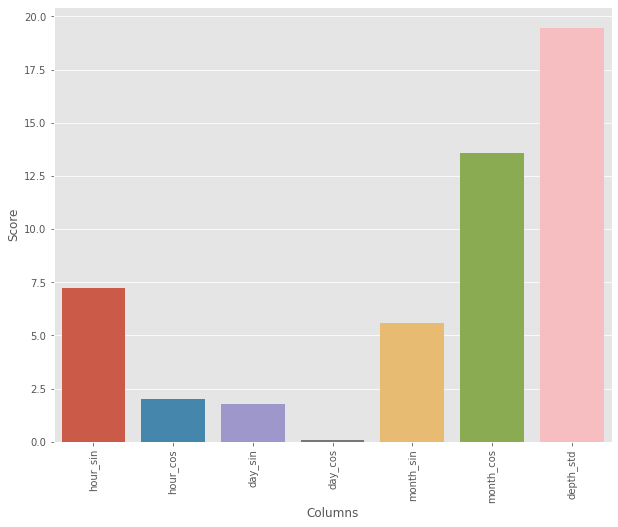

Sea turtles - Anova 

Feature hour_sin score: 27.149236 p_valor: 1.9151446328482742e-07
Feature hour_cos score: 3.761605 p_valor: 0.05246599266376864
Feature day_sin score: 6.234989 p_valor: 0.012538553458942137
Feature day_cos score: 0.134578 p_valor: 0.7137379786266778
Feature month_sin score: 3.016751 p_valor: 0.08243449741427399
Feature month_cos score: 0.586745 p_valor: 0.44369582919808237
Feature depth_std score: 11.940872 p_valor: 0.000551088852937712


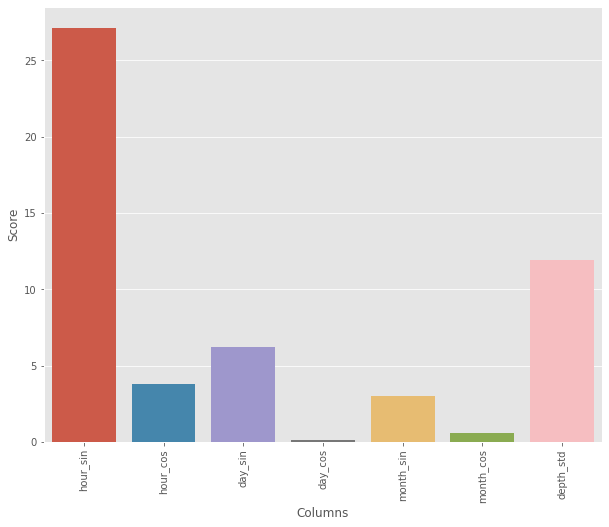

Groupers - Anova 

Feature hour_sin score: 30.669559 p_valor: 3.124708679137934e-08
Feature hour_cos score: 24.184990 p_valor: 8.86901361439785e-07
Feature day_sin score: 6.385705 p_valor: 0.011517252376681015
Feature day_cos score: 7.038941 p_valor: 0.007986291520111084
Feature month_sin score: 37.018126 p_valor: 1.2066140938004317e-09
Feature month_cos score: 5.812400 p_valor: 0.0159287414998766
Feature depth_std score: 112.128060 p_valor: 4.3846547451443687e-26


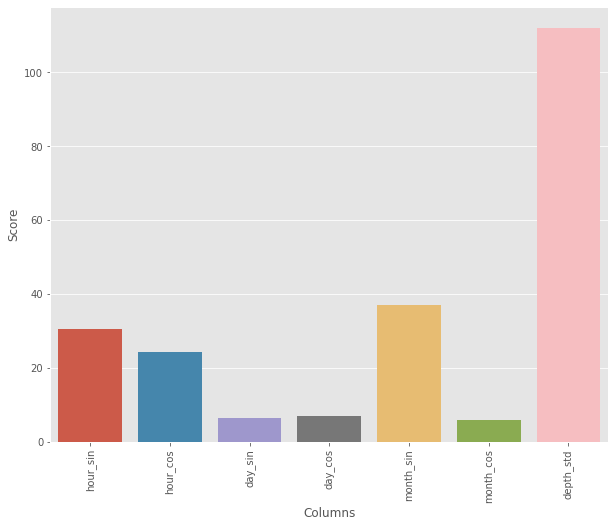

In [30]:
fs_anova = SelectKBest(score_func=f_classif, k='all')

for col in target_cols:
    fs_anova.fit(X[numerical_columns], Y[col])
    X_fs = fs_anova.transform(X[numerical_columns])
    
    print("\033[1m"+col+"\033[0m", '-', '\033[1mAnova\033[0m', "\n")
    
    for i,col in enumerate(numerical_columns):
        print('Feature \033[1m%s score:\033[0m %f \033[1mp_valor:\033[0m %s' % (col, fs_anova.scores_[i],\
                                                                                fs_anova.pvalues_[i]))

    plt.figure(figsize=(10,8))
    ax=sns.barplot(x=numerical_columns, y=fs_anova.scores_)
    ax.set(xlabel='Columns', ylabel='Score')
    plt.xticks(rotation=90)
    plt.show()

Depending on the animal, some variables are more influents than others, but, in global, all seem to be correlated with the target